In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib_venn import venn2, venn2_circles, venn3, venn3_circles
import seaborn as sns
import numpy as np
import re

In [ ]:
def add_site_mean(df):
    
    GT_DP_cols = [col for col in df.columns if '.DP' in col]
    site_means = df[GT_DP_cols].mean(axis=1)
    df_out = df.assign(SITE_MEAN=site_means)
    
    return df_out
    
gatk_snps_df = add_site_mean(gatk_snps_df)
free_snps_df = add_site_mean(free_snps_df)

In [7]:
def add_gq_prop(df):
    
    GT_GQ_cols = [col for col in df.columns if '.GQ' in col]
    num_genotypes = len(GT_GQ_cols)
    gq_prop = (df[GT_GQ_cols] >= 30).sum(axis = 1) / num_genotypes
    df_out = df.assign(GQ_PROP=gq_prop)
    
    return df_out

gatk_snps_df = add_gq_prop(gatk_snps_df)
free_snps_df = add_gq_prop(free_snps_df)

In [4]:
def calc_sor(row):
    # Get strand counts and add 1 to avoid dividing by zero
    refFw = int(row['SRF']) + 1 
    refRv = int(row['SRR']) + 1 
    altFw = int(row['SAF']) + 1 
    altRv = int(row['SAR']) + 1 
    
    symmetricalRatio = ((refFw*altRv)/(altFw*refRv)) + ((altFw*refFw)/(altFw*refRv))
    refRatio = refRv/refFw
    altRatio = altRv/altFw
    SOR = np.log(symmetricalRatio) + np.log(refRatio) - np.log(altRatio)
    return(SOR)


def calc_ab(df):
    AD_cols = [col for col in df.columns if '.AD' in col]
    GT_cols = [col for col in df.columns if '.GT' in col]
    AD_col = df[AD_cols].values.tolist()
    GT_col = df[GT_cols].values.tolist()
    REF_list = df['REF'].values.tolist()
    ALT_list = df['ALT'].values.tolist()

    AB_vals = []
    for i in range(len(AD_col)):
        REF_allele = REF_list[i]
        ALT_allele = ALT_list[i]
        AB = []
        for j in range(len(GT_col[i])):
            if '.' not in GT_col[i][j]:
                first_allele = re.split('/|\|', GT_col[i][j])[0]
                second_allele = re.split('/|\|', GT_col[i][j])[1]
                if first_allele != second_allele:
                    AD_vals = AD_col[i][j].split(',')
                    if first_allele == REF_allele:
                        AD_REF = int(AD_vals[0])
                        AD_ALT = int(AD_vals[1])
                    elif first_allele == ALT_allele:
                        AD_REF = int(AD_vals[1])
                        AD_ALT = int(AD_vals[0])
                    if AD_ALT == 0 and AD_REF == 0:
                        pass
                    else:
                        GT_AB = AD_ALT / (AD_ALT + AD_REF)
                        AB.append(GT_AB)
        if AB:
            AB = np.mean(AB)
        else:
            AB = 0
        AB_vals.append(AB)

    return(AB_vals)
    

def prefilter_and_add_cols(df, program):
    """Filter for biallelic and calculate some additional quality metrics
    
    Args:
        df (:obj: Pandas dataframe): Pandas dataframe with SNPs as rows and
        quality metrics and genotype stats as columns.
        program (str): Progrma used to identify variants ('gatk' or 'freebayes')
        
    Returns: (:obj: Pandas dataframe): 
        Pandas dataframe with with only biallelic sites and additional quality
        metrics: site-mean depth, % missing genotypes, MAF.
    """
    
    ## OPERATIONS TO RUN ON ALL SNP TABLES

    # Remove multi-allelic sites
    num_multi_allelic = len(df[df['MULTI-ALLELIC'] == True])
    df_mod = df[df['MULTI-ALLELIC'] == False]
    num_biallelic = len(df_mod)
    print("Removed {0} multi-allelic sites. {1} biallelic sites remaining ".format(num_multi_allelic, num_biallelic))
    
    # Calculate mean site depth across all genotpyes
    GT_DP_cols = [col for col in df_mod.columns if '.DP' in col]
    site_means = df_mod[GT_DP_cols].mean(axis=1)
    df_mod = df_mod.assign(SITE_MEAN=site_means)
    
    # Minor allele frequency
    df_mod['AF'] = pd.to_numeric(df_mod['AF'])
    df_mod['AF-REF'] = pd.to_numeric(1 - df_mod['AF'])
    maf = np.min(df_mod[['AF-REF', 'AF']], axis=1)
    df_mod = df_mod.assign(MAF=maf)
    
    # Fraction of missing genotype calls
    frac_miss = pd.to_numeric(df_mod['NO-CALL']) / pd.to_numeric(df_mod['NSAMPLES'])
    df_mod = df_mod.assign(FRAC_MISS=frac_miss)
    
    # Fraction genotype quality 
    GT_GQ_cols = [col for col in df_mod.columns if '.GQ' in col]
    count_HQ_GT = (df_mod[GT_GQ_cols] > 20).sum(axis=1)
    frac_HC_GT = count_HQ_GT / pd.to_numeric(df_mod['NSAMPLES'])
    df_mod = df_mod.assign(FRAC_HQ_GT=frac_HC_GT)
    
    # Quality by depth
    QUAL_BY_DEPTH = pd.to_numeric(df_mod['QUAL']) / pd.to_numeric(df_mod['DP'])
    df_mod = df_mod.assign(QUAL_BY_DEPTH=QUAL_BY_DEPTH)
    
    ## OPERATION ON FREEBAYES SNP TABLE ##
    
    if program == 'freebayes':
        df_mod['SOR'] = df_mod.apply(calc_sor, axis=1)
        df_mod['PROGRAM'] = 'freebayes'
        df_mod['MQM'] = pd.to_numeric(df_mod['MQM'])
        df_mod['MQMR'] = pd.to_numeric(df_mod['MQMR'])
        MQM_BY_MQMR = df_mod['MQM'] / df_mod['MQMR']
        df_mod = df_mod.assign(MQM_BY_MQMR=MQM_BY_MQMR)
        df_mod['MQM_BY_MQMR'] = df_mod['MQM_BY_MQMR'].replace([np.inf, -np.inf], np.nan)
        AB_vals = calc_ab(df_mod)
        df_mod = df_mod.assign(AB_CALC=AB_vals)
        cols = ['CHROM', 'POS', 'QUAL', 'REF', 'ALT', 'DP', 'AF', 'AB', 'MQM', 'MQMR', 'MQM_BY_MQMR', 'PAIRED', 'QUAL_BY_DEPTH', 
                'PAIREDR', 'NO-CALL', 'NSAMPLES', 'SOR', 'MAF', 'FRAC_MISS', 'FRAC_HQ_GT', 'SITE_MEAN', 'PROGRAM', 'AB_CALC']
#         df_mod = df_mod[df_mod['QUAL'] >= 30]
    
    if program == 'gatk':
        AB_vals = calc_ab(df_mod)
        df_mod = df_mod.assign(AB_CALC=AB_vals)
        df_mod['PROGRAM'] = 'gatk'
        cols = ['CHROM', 'POS', 'QUAL', 'REF', 'ALT', 'DP', 'AF', 'AB_CALC', 'MQ', 'MQRankSum', 'NO-CALL', 
                'SITE_MEAN', 'NSAMPLES', 'SOR', 'MAF', 'FRAC_MISS', 'FRAC_HQ_GT', 'PROGRAM', 'QUAL_BY_DEPTH']
        
    # Subset cols
    GT_cols = [col for col in df.columns if '.GT' in col]
    GQ_cols = [col for col in df.columns if '.GQ' in col]
    df_mod = df_mod[cols + GT_cols + GQ_cols]
    
    return(df_mod)

In [43]:
prefiltered_gatk_snps_df = prefilter_and_add_cols(gatk_snps_df, program = 'gatk')
prefiltered_free_snps_df = prefilter_and_add_cols(free_snps_df, program = 'freebayes')

Removed 168307 multi-allelic sites. 2806656 biallelic sites remaining 
Removed 52037 multi-allelic sites. 2745362 biallelic sites remaining 


In [64]:
prefiltered_free_snps_df.head()

,Unnamed: 0,CHROM,POS,QUAL,REF,ALT,DP,AF,AB,MQM,...,s_100_13.GQ,s_116_1.GQ,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ
0,0,CM019101.1,1287,15.58,T,G,6,0.333333,0.000000,40.0000,...,NaN,NaN,NaN,NaN,16.0,NaN,0.0,16.0,NaN,NaN
1,1,CM019101.1,1660,18.74,G,A,4,0.500000,0.000000,40.0000,...,NaN,NaN,1.0,NaN,NaN,9.0,NaN,NaN,NaN,NaN
2,2,CM019101.1,5343,54.91,C,G,2,1.000000,0.000000,40.0000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,NaN
3,3,CM019101.1,10043,8.36,T,C,36,0.083333,0.500000,50.0000,...,56.0,32.0,NaN,41.0,53.0,29.0,NaN,NaN,8.0,NaN
4,4,CM019101.1,10070,348.79,G,A,43,0.500000,0.421053,54.1667,...,99.0,3.0,NaN,60.0,72.0,0.0,NaN,NaN,41.0,NaN


In [63]:
prefiltered_gatk_snps_df.head()

,Unnamed: 0,CHROM,POS,QUAL,REF,ALT,DP,AF,AB_CALC,MQ,...,s_100_13.GQ,s_116_1.GQ,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ
0,0,CM019101.1,3850,88.21,T,C,3,1.000,0.000000,40.00,...,NaN,NaN,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1,CM019101.1,10043,32.79,T,C,24,0.083,0.666667,47.61,...,30.0,3.0,NaN,9.0,18.0,3.0,NaN,NaN,33.0,NaN
2,2,CM019101.1,10070,357.09,G,A,39,0.667,0.345238,54.91,...,99.0,3.0,NaN,9.0,31.0,3.0,NaN,NaN,9.0,NaN
3,3,CM019101.1,10084,78.02,G,T,44,0.071,0.666667,53.18,...,51.0,3.0,NaN,9.0,72.0,3.0,NaN,3.0,15.0,NaN
4,4,CM019101.1,10102,889.38,C,T,48,0.667,0.576471,54.23,...,99.0,3.0,NaN,30.0,18.0,3.0,NaN,NaN,15.0,NaN


In [61]:
# Write prefiltered dataframe to disk
outpath = "../data/raw/snp_tables/"
prefiltered_free_snps_df.to_csv(outpath + "prefiltered_snps_freebayes.table", sep="\t")
prefiltered_gatk_snps_df.to_csv(outpath + "prefiltered_snps_gatk.table", sep="\t")

In [62]:
# Read in prefiltered SNP tables
inpath = "../data/raw/snp_tables/"
prefiltered_gatk_snps_df = pd.read_table(inpath + "prefiltered_snps_gatk.table", sep = "\t")
prefiltered_free_snps_df = pd.read_table(inpath + "prefiltered_snps_freebayes.table", sep = "\t")

## Fraction of missing sites by sample

It's common to remove samples that have a high proportion of missing data (e.g., >25%) <br>
The cutoff should be based on the distribution of missing data across all individuals <br>

**Note** I didn't implement this filter here since the distribution can't be accurately <br>
estimated from only 10 test individuals. Nonetheless, The dicutionaries below show that for both <br>
`GATK` and `freebayes`, 2 samples (s_23_12 and s_54_9) have a high proportion of missing data <br>
and we'll have to account for this.

In [71]:
def missing_sites_by_sample(df, program):
    """Calculate percent missing sites by sample
    
    Args:
        df (:obj: Pandas dataframe): Pandas dataframe with SNPs as rows and
        quality metrics and genotype stats as columns.
        program (str): Whether SNPs originated from 'GATK' or 'freebayes'
        
    Returns:
        Dictionary with sample ID as keys and the percent of sites with 
        missing genotype calls
    """
    GT_GT_cols = [col for col in df.columns if '.GT' in col]
    frac_missing = {}
    for col in GT_GT_cols:
        
        if program == "gatk":
            frac = len(df[[col]][(df[col] == './.') | (df[col] == '.|.')]) / len(df)
        elif program == "freebayes":
            frac = len(df[[col]][(df[col] == '.')]) / len(df)
        
        frac_missing[col] = round(frac, 3)
    
    return(frac_missing)

In [72]:
gatk_frac_missing_by_sample = missing_sites_by_sample(prefiltered_gatk_snps_df, program = 'gatk')
free_frac_missing_by_sample = missing_sites_by_sample(prefiltered_free_snps_df, program = 'freebayes')

In [73]:
gatk_frac_missing_by_sample

{'s_100_13.GT': 0.133,
 's_116_1.GT': 0.09,
 's_23_12.GT': 0.757,
 's_37_18.GT': 0.131,
 's_41_13.GT': 0.092,
 's_43_15.GT': 0.131,
 's_54_9.GT': 0.701,
 's_7_7.GT': 0.104,
 's_83_10.GT': 0.143,
 's_97_3.GT': 0.137}

In [74]:
free_frac_missing_by_sample

{'s_100_13.GT': 0.086,
 's_116_1.GT': 0.049,
 's_23_12.GT': 0.667,
 's_37_18.GT': 0.079,
 's_41_13.GT': 0.052,
 's_43_15.GT': 0.081,
 's_54_9.GT': 0.67,
 's_7_7.GT': 0.06,
 's_83_10.GT': 0.09,
 's_97_3.GT': 0.09}

## Filtering 

Filtering here will be based on [this tutorial](http://www.ddocent.com/filtering/) by
Jon Puritz, with some modifications, which are similiar to those used <br>
by [Julia Kreiner](https://github.com/jkreinz/Amaranthus-population-genomics/blob/master/snp_calling_filtering/filtering_vcfs.sh) in her recent paper.

Quality metrics

- Missing genotypes:
    - Keep sites with at least 80% high-quality genotype calls (Phred > 20)
- Depth:
    - Keep if mean depth per site is between 5X and 40X
- Allele balance: Ratio of reads showing the ALT allele to all reads. 
    - Keep if between 0.25 and 0.75, or equal to 0 (all individuals are homozygous for one of the two variants)
- Strand bias:
    - Keep if SOR less than 3
- Quality and depth
    - Keep if:
        - QUAL > 30
        - QUAL / DP > 0.25
        
## Plot histograms of overlapping quality metrics

In [10]:
prefiltered_gatk_snps_df_FRAC = prefiltered_gatk_snps_df[['FRAC_HQ_GT', 'PROGRAM']]
prefiltered_free_snps_df_FRAC = prefiltered_free_snps_df[['FRAC_HQ_GT', 'PROGRAM']]
FRAC_HQ_GT_df = pd.DataFrame.append(prefiltered_gatk_snps_df_FRAC, prefiltered_free_snps_df_FRAC)

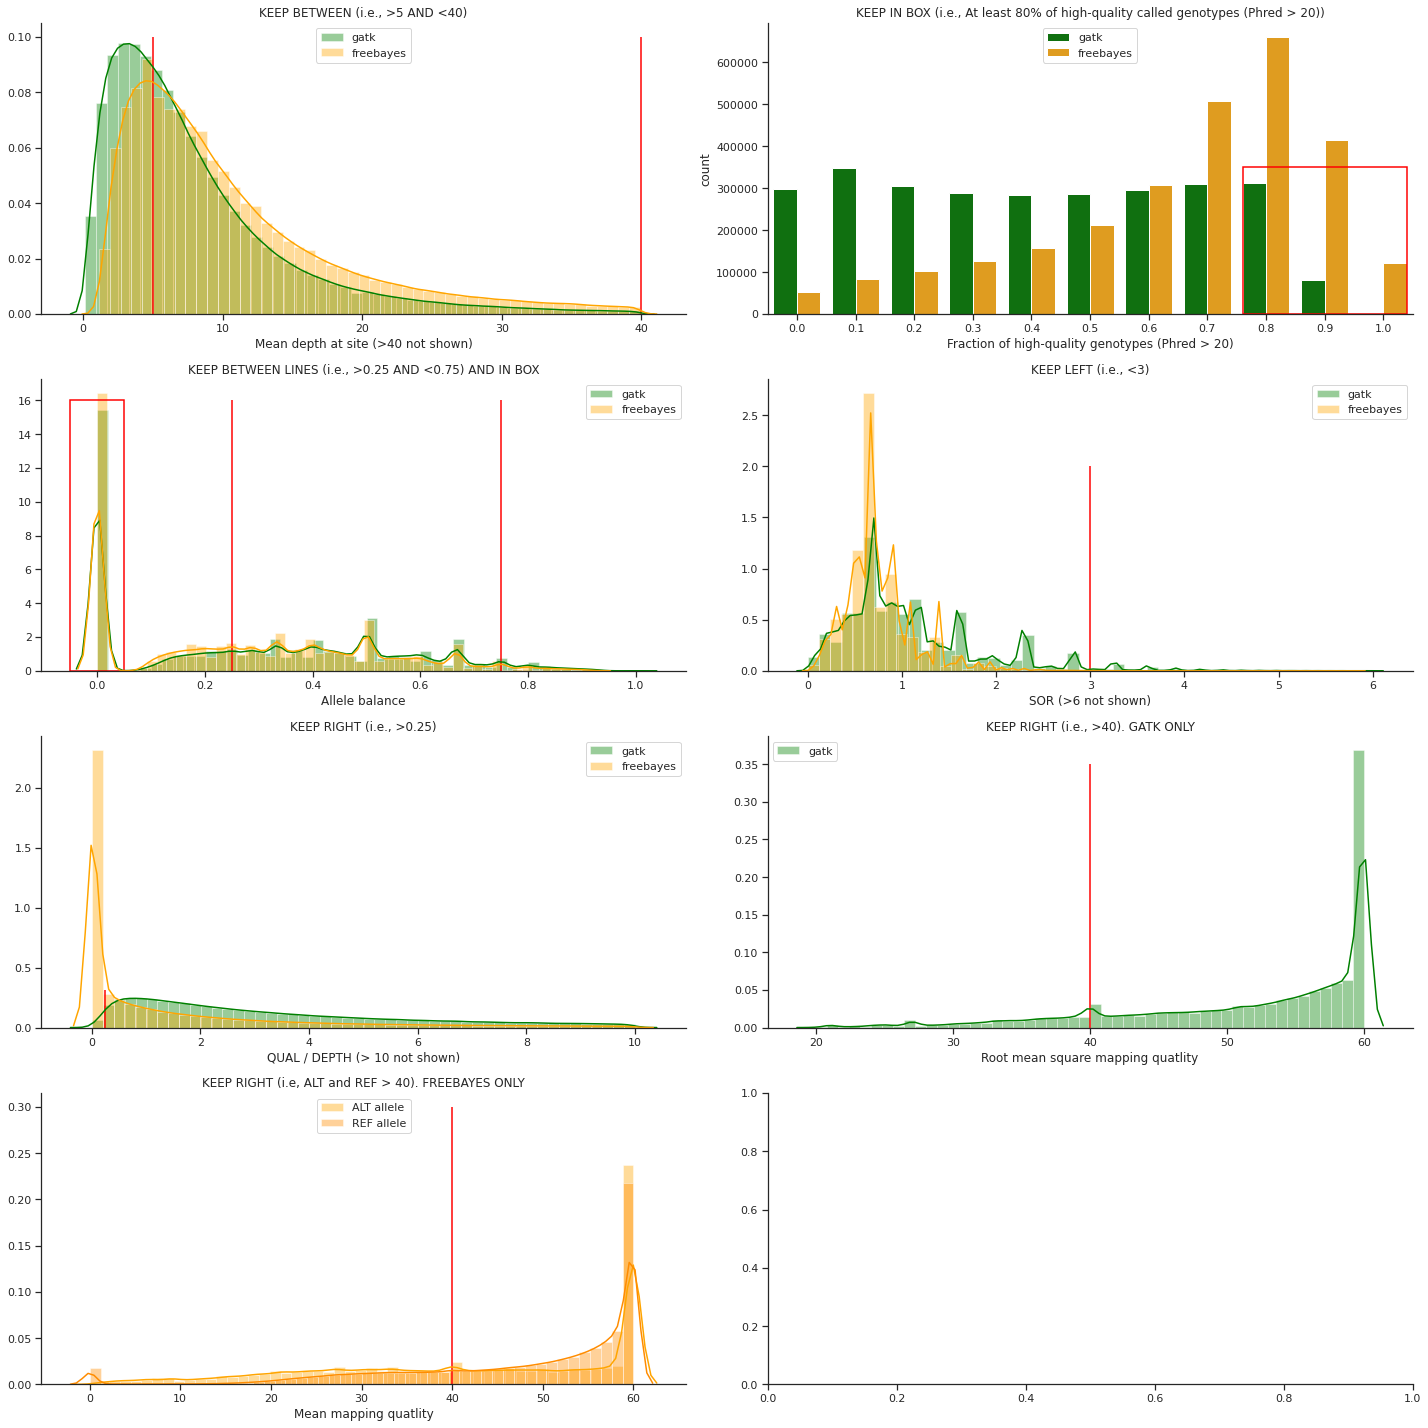

In [11]:
# First set up the figure, the axis, and the plot elemto_numpy want to animate
sns.set(style="ticks")
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(20, 20))
sns.despine(right=True, top=True)

# SITE_MEAN — Mean read depth at site across samples 
sns.distplot(prefiltered_gatk_snps_df['SITE_MEAN'][prefiltered_gatk_snps_df['SITE_MEAN'] < 40], label="gatk", color="green", ax=axes[0, 0])
sns.distplot(prefiltered_free_snps_df['SITE_MEAN'][prefiltered_free_snps_df['SITE_MEAN'] < 40], label="freebayes", color="orange", ax=axes[0, 0])
axes[0, 0].set_xlabel("Mean depth at site (>40 not shown)")
axes[0, 0].vlines(5, 0, 0.1, linestyle="solid", color="red", lw=1.5)
axes[0, 0].vlines(40, 0, 0.1, linestyle="solid", color="red", lw=1.5)
axes[0, 0].set_title("KEEP BETWEEN (i.e., >5 AND <40)")
axes[0, 0].legend(loc='upper center')

# # FRAC_HQ_GT-MISS
sns.countplot(x="FRAC_HQ_GT", hue="PROGRAM", data=FRAC_HQ_GT_df, palette=["green", "orange"], ax=axes[0, 1])
axes[0, 1].set_xlabel("Fraction of high-quality genotypes (Phred > 20)")
axes[0, 1].set_title("KEEP IN BOX (i.e., At least 80% of high-quality called genotypes (Phred > 20))")
axes[0, 1].add_patch(
    patches.Rectangle(
        xy=(7.6, 0),  # point of origin.
        width=2.8,
        height=350000,
        linewidth=1.5,
        color='red',
        fill=False
    )
)
axes[0, 1].legend(loc='upper center', title='')

# AB
sns.distplot(prefiltered_gatk_snps_df['AB_CALC'], label="gatk", color="green", ax=axes[1, 0])
sns.distplot(prefiltered_free_snps_df['AB_CALC'], label="freebayes", color="orange", ax=axes[1, 0])
axes[1, 0].set_xlabel("Allele balance")
axes[1, 0].vlines(0.25, 0, 16, linestyle="solid", color="red", lw=1.5)
axes[1, 0].vlines(0.75, 0, 16, linestyle="solid", color="red", lw=1.5)
axes[1, 0].add_patch(
    patches.Rectangle(
        xy=(-0.05, 0),  # point of origin.
        width=0.1,
        height=16,
        linewidth=1.5,
        color='red',
        fill=False
    )
)
axes[1, 0].set_title("KEEP BETWEEN LINES (i.e., >0.25 AND <0.75) AND IN BOX")
axes[1, 0].legend()

# SOR
sns.distplot(prefiltered_gatk_snps_df['SOR'][prefiltered_gatk_snps_df['SOR'] < 6], label="gatk", color="green", ax=axes[1, 1])
sns.distplot(prefiltered_free_snps_df['SOR'][prefiltered_free_snps_df['SOR'] < 6], label="freebayes", color="orange", ax=axes[1, 1])
axes[1, 1].set_xlabel("SOR (>6 not shown)")
axes[1, 1].vlines(3, 0, 2, linestyle="solid", color="red", lw=1.5)
axes[1, 1].set_title("KEEP LEFT (i.e., <3)")
axes[1, 1].legend()

# QUAL / DP
sns.distplot(prefiltered_gatk_snps_df['QUAL_BY_DEPTH'][prefiltered_gatk_snps_df['QUAL_BY_DEPTH'] < 10], label="gatk", color="green", ax=axes[2, 0])
sns.distplot(prefiltered_free_snps_df['QUAL_BY_DEPTH'][prefiltered_free_snps_df['QUAL_BY_DEPTH'] < 10], label="freebayes", color="orange", ax=axes[2, 0])
axes[2, 0].set_xlabel("QUAL / DEPTH (> 10 not shown)")
axes[2, 0].vlines(0.25, 0, 0.31, linestyle="solid", color="red", lw=1.5)
axes[2, 0].set_title("KEEP RIGHT (i.e., >0.25)")
axes[2, 0].legend()

# MQ
sns.distplot(prefiltered_gatk_snps_df['MQ'], label="gatk", color="green", ax=axes[2, 1])
axes[2, 1].set_xlabel("Root mean square mapping quatlity")
axes[2, 1].vlines(40, 0, 0.35, linestyle="solid", color="red", lw=1.5)
axes[2, 1].set_title("KEEP RIGHT (i.e., >40). GATK ONLY")
axes[2, 1].legend()

# MQ
sns.distplot(prefiltered_free_snps_df['MQM'], label="ALT allele", color="orange", ax=axes[3, 0])
sns.distplot(prefiltered_free_snps_df['MQMR'], label="REF allele", color="darkorange", ax=axes[3, 0])
axes[3, 0].set_xlabel("Mean mapping quatlity")
axes[3, 0].vlines(40, 0, 0.30, linestyle="solid", color="red", lw=1.5)
axes[3, 0].set_title("KEEP RIGHT (i.e, ALT and REF > 40). FREEBAYES ONLY")
axes[3, 0].legend(loc='upper center')

plt.tight_layout()

## Impose filtering conditions from above on both datasets

## Look into VCFs that were soft-filtered with `bcftools`

Here I'll explore the SNPs retured by `GATK` and `freebayes` following soft-filtering with `bcftools`

In [121]:
def filter_pass(df):
    
    df_out = df[df['FILTER'] == 'PASS']
    return df_out
    
gatk_bcftools_filter_snps = filter_pass(gatk_snps_df)
free_bcftools_filter_snps = filter_pass(free_snps_df)

In [17]:
# List of positions that occur in both filtered datasets
intersection = list(set(gatk_bcftools_filter_snps['POS'].values.tolist()) & set(free_bcftools_filter_snps['POS'].values.tolist()))

# SNPs called by GATK only
gatk_only = gatk_bcftools_filter_snps[~gatk_bcftools_filter_snps['POS'].isin(intersection)]['POS'].values.tolist()

# SNPs called by freebayes only
freebayes_only = free_bcftools_filter_snps[~free_bcftools_filter_snps['POS'].isin(intersection)]['POS'].values.tolist()

# SNPs not called by either program
neither = gatk_snps_df[~gatk_snps_df['POS'].isin(intersection + gatk_only + freebayes_only)]['POS'].values.tolist()

# Randomly select 25 SNPs in each category
np.random.seed(42)
rand25_intersection = np.random.choice(intersection, size = 25)
rand25_gatk = np.random.choice(gatk_only, size = 25)
rand25_freebayes = np.random.choice(freebayes_only, size = 25)
rand25_neither = np.random.choice(neither, size = 25)

In [12]:
# Intersection dataframe with Sites called by both GATK and Freebayes
cols = ['CHROM', 'POS', 'QUAL', 'DP', 'FILTER'] + [col for col in free_bcftools_filter_snps.columns if '.GT' in col] + [col for col in free_bcftools_filter_snps.columns if '.GQ' in col]
free_intersection = free_snps_df[cols][free_snps_df['POS'].isin(rand25_intersection)]
free_intersection['PROGRAM'] = 'FREEBAYES'
gatk_intersection = gatk_snps_df[cols][gatk_snps_df['POS'].isin(rand25_intersection)]
gatk_intersection['PROGRAM'] = 'GATK'
intersection_df = pd.DataFrame.append(free_intersection, gatk_intersection).sort_values(by='POS')
intersection_df['CATEGORY'] = 'BOTH'
intersection_df.head()

,CHROM,POS,QUAL,DP,FILTER,s_100_13.GT,s_116_1.GT,s_23_12.GT,s_37_18.GT,s_41_13.GT,...,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ,PROGRAM,CATEGORY
92429,CM019101.1,3786075,95.06,282,PASS,C/C,C/C,C/C,C/C,C/C,...,80.0,99.0,99.0,65.0,62.0,99.0,68.0,79.0,FREEBAYES,BOTH
98362,CM019101.1,3786075,398.48,216,PASS,C/C,C/C,C/C,C/C,C/C,...,18.0,72.0,72.0,99.0,NaN,36.0,99.0,39.0,GATK,BOTH
99872,CM019101.1,3829553,170.78,108,PASS,C/C,C/C,./.,C/C,C/C,...,NaN,42.0,48.0,33.0,NaN,30.0,36.0,99.0,GATK,BOTH
93699,CM019101.1,3829553,122.93,115,PASS,C/C,C/C,.,C/C,C/C,...,NaN,72.0,78.0,59.0,NaN,56.0,62.0,99.0,FREEBAYES,BOTH
99157,CM019101.1,4046451,352.06,196,PASS,G/G,G/G,G/G,G/G,G/G,...,25.0,76.0,76.0,98.0,41.0,67.0,99.0,64.0,FREEBAYES,BOTH


In [13]:
# Site called by GATK only, with corresponding site in freebayes DF
gatk_only_gatk = gatk_snps_df[cols][gatk_snps_df['POS'].isin(rand25_gatk)]
gatk_only_gatk['PROGRAM'] = 'GATK'
gatk_only_free = free_snps_df[cols][free_snps_df['POS'].isin(rand25_gatk)]
gatk_only_free['PROGRAM'] = 'FREEBAYES'
gatk_only_df = pd.DataFrame.append(gatk_only_gatk, gatk_only_free).sort_values(by='POS')
gatk_only_df['CATEGORY'] = 'GATK_ONLY'
gatk_only_df.head()

,CHROM,POS,QUAL,DP,FILTER,s_100_13.GT,s_116_1.GT,s_23_12.GT,s_37_18.GT,s_41_13.GT,...,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ,PROGRAM,CATEGORY
90172,CM019101.1,3528998,160.03,193,PASS,C/T,C/T,./.,C/T,C/C,...,NaN,83.0,72.0,57.0,6.0,99.0,51.0,72.0,GATK,GATK_ONLY
84718,CM019101.1,3528998,0.14,198,"LowQual,FRAC_HQ_GT",C/T,C/T,.,C/T,C/C,...,NaN,0.0,99.0,99.0,77.0,99.0,99.0,99.0,FREEBAYES,GATK_ONLY
198115,CM019101.1,7487074,202.60,445,PASS,C/C,C|T,C/C,C/C,C/C,...,15.0,99.0,99.0,93.0,6.0,99.0,99.0,99.0,GATK,GATK_ONLY
248095,CM019101.1,9388553,72.27,239,PASS,G/A,G/G,G/G,G/G,G/G,...,6.0,52.0,99.0,93.0,NaN,48.0,63.0,43.0,GATK,GATK_ONLY
235038,CM019101.1,9388553,0.00,356,LowQual,G/A,G/G,G/G,G/G,G/G,...,99.0,99.0,99.0,99.0,NaN,99.0,99.0,99.0,FREEBAYES,GATK_ONLY


In [14]:
# Site called by freebayes only, with corresponding site in GATK DF
free_only_gatk = gatk_snps_df[cols][gatk_snps_df['POS'].isin(rand25_freebayes)]
free_only_gatk['PROGRAM'] = 'GATK'
free_only_free = free_snps_df[cols][free_snps_df['POS'].isin(rand25_freebayes)]
free_only_free['PROGRAM'] = 'FREEBAYES'
free_only_df = pd.DataFrame.append(free_only_gatk, free_only_free).sort_values(by='POS')
free_only_df['CATEGORY'] = 'FREE_ONLY'
free_only_df.head()

,CHROM,POS,QUAL,DP,FILTER,s_100_13.GT,s_116_1.GT,s_23_12.GT,s_37_18.GT,s_41_13.GT,...,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ,PROGRAM,CATEGORY
100701,CM019101.1,3854392,639.71,95,FRAC_HQ_GT,G|A,G/G,./.,G/G,G|A,...,NaN,21.0,99.0,34.0,NaN,66.0,99.0,42.0,GATK,FREE_ONLY
94435,CM019101.1,3854392,476.23,101,PASS,G/A,G/G,.,G/G,G/A,...,NaN,55.0,49.0,70.0,NaN,65.0,99.0,71.0,FREEBAYES,FREE_ONLY
116807,CM019101.1,4737161,135.72,157,PASS,A/A,A/A,.,A/A,A/A,...,NaN,76.0,85.0,42.0,6.0,54.0,91.0,91.0,FREEBAYES,FREE_ONLY
233505,CM019101.1,9340215,40.59,103,PASS,A/A,A/A,A/A,A/A,A/A,...,34.0,49.0,58.0,28.0,64.0,41.0,40.0,2.0,FREEBAYES,FREE_ONLY
246301,CM019101.1,9340215,109.98,95,FRAC_HQ_GT,A/A,A/A,A/A,A/A,A/A,...,6.0,18.0,27.0,0.0,12.0,99.0,9.0,19.0,GATK,FREE_ONLY


In [15]:
# Sites called by neither program
neither_gatk = gatk_snps_df[cols][gatk_snps_df['POS'].isin(rand25_neither)]
neither_gatk['PROGRAM'] = 'GATK'
neither_free = free_snps_df[cols][free_snps_df['POS'].isin(rand25_neither)]
neither_free['PROGRAM'] = 'FREEBAYES'
neither_df = pd.DataFrame.append(neither_gatk, neither_free).sort_values(by='POS')
neither_df['CATEGORY'] = 'NEITHER'
neither_df.head()

,CHROM,POS,QUAL,DP,FILTER,s_100_13.GT,s_116_1.GT,s_23_12.GT,s_37_18.GT,s_41_13.GT,...,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ,PROGRAM,CATEGORY
159122,CM019101.1,6080752,75.64,40,FRAC_HQ_GT,T/T,T/T,./.,T/T,T/T,...,NaN,3.0,15.0,15.0,6.0,21.0,0.0,9.0,GATK,NEITHER
162520,CM019101.1,6213491,307.37,36,FRAC_HQ_GT,A|G,A/A,A/A,./.,A|G,...,9.0,NaN,99.0,12.0,12.0,9.0,9.0,3.0,GATK,NEITHER
152130,CM019101.1,6213491,156.98,42,FRAC_HQ_GT,A/G,A/A,A/A,G/G,A/G,...,22.0,0.0,99.0,31.0,25.0,22.0,28.0,19.0,FREEBAYES,NEITHER
338100,CM019101.1,12559221,85.51,4,FRAC_HQ_GT,./.,./.,./.,./.,C|C,...,NaN,NaN,6.0,NaN,NaN,NaN,3.0,NaN,GATK,NEITHER
323218,CM019101.1,12559221,114.65,16,FRAC_HQ_GT,G/C,.,.,G/G,C/C,...,NaN,6.0,12.0,1.0,NaN,NaN,6.0,18.0,FREEBAYES,NEITHER


In [16]:
all_rand_snps = pd.DataFrame.append(intersection_df, gatk_only_df).sort_values(by='POS')
all_rand_snps = pd.DataFrame.append(all_rand_snps, free_only_df).sort_values(by='POS')
all_rand_snps = pd.DataFrame.append(all_rand_snps, neither_df).sort_values(by='POS')
all_rand_snps.head(20)

,CHROM,POS,QUAL,DP,FILTER,s_100_13.GT,s_116_1.GT,s_23_12.GT,s_37_18.GT,s_41_13.GT,...,s_23_12.GQ,s_37_18.GQ,s_41_13.GQ,s_43_15.GQ,s_54_9.GQ,s_7_7.GQ,s_83_10.GQ,s_97_3.GQ,PROGRAM,CATEGORY
90172,CM019101.1,3528998,160.03,193,PASS,C/T,C/T,./.,C/T,C/C,...,NaN,83.0,72.0,57.0,6.0,99.0,51.0,72.0,GATK,GATK_ONLY
84718,CM019101.1,3528998,0.14,198,"LowQual,FRAC_HQ_GT",C/T,C/T,.,C/T,C/C,...,NaN,0.0,99.0,99.0,77.0,99.0,99.0,99.0,FREEBAYES,GATK_ONLY
92429,CM019101.1,3786075,95.06,282,PASS,C/C,C/C,C/C,C/C,C/C,...,80.0,99.0,99.0,65.0,62.0,99.0,68.0,79.0,FREEBAYES,BOTH
98362,CM019101.1,3786075,398.48,216,PASS,C/C,C/C,C/C,C/C,C/C,...,18.0,72.0,72.0,99.0,NaN,36.0,99.0,39.0,GATK,BOTH
93699,CM019101.1,3829553,122.93,115,PASS,C/C,C/C,.,C/C,C/C,...,NaN,72.0,78.0,59.0,NaN,56.0,62.0,99.0,FREEBAYES,BOTH
99872,CM019101.1,3829553,170.78,108,PASS,C/C,C/C,./.,C/C,C/C,...,NaN,42.0,48.0,33.0,NaN,30.0,36.0,99.0,GATK,BOTH
100701,CM019101.1,3854392,639.71,95,FRAC_HQ_GT,G|A,G/G,./.,G/G,G|A,...,NaN,21.0,99.0,34.0,NaN,66.0,99.0,42.0,GATK,FREE_ONLY
94435,CM019101.1,3854392,476.23,101,PASS,G/A,G/G,.,G/G,G/A,...,NaN,55.0,49.0,70.0,NaN,65.0,99.0,71.0,FREEBAYES,FREE_ONLY
99157,CM019101.1,4046451,352.06,196,PASS,G/G,G/G,G/G,G/G,G/G,...,25.0,76.0,76.0,98.0,41.0,67.0,99.0,64.0,FREEBAYES,BOTH
105199,CM019101.1,4046451,464.44,187,PASS,G/G,G/G,G/G,G/G,G/G,...,6.0,48.0,57.0,72.0,42.0,45.0,81.0,45.0,GATK,BOTH


In [22]:
# Write randomly chosen 100 SNPs to table
outpath = "../data/raw/snp_tables/"
all_rand_snps.to_csv(outpath + "rand100Snps_gatk_freebayes.table", sep="\t")

In [26]:
positions = sorted(list(set(all_rand_snps['POS'].values.tolist())))
positions[0:10]

[3528998,
 3786075,
 3829553,
 3854392,
 4046451,
 4737161,
 5492600,
 6080752,
 6213491,
 7487074]

In [32]:
cols = ['POS', 'CATEGORY']
outpath = "../data/raw/snp_tables/"
all_rand_snps_uniqueRows = all_rand_snps[cols].drop_duplicates()
all_rand_snps_uniqueRows.to_csv(outpath + "rand100Snps_gatk_freebayes_POSonly.csv", sep=",")

,POS,CATEGORY
90172,3528998,GATK_ONLY
92429,3786075,BOTH
93699,3829553,BOTH
100701,3854392,FREE_ONLY
99157,4046451,BOTH


In [24]:
# Write regions BED file used to subset bam around 100 random SNPs
outpath = "../resources/rand100Snps_GATK_freebayes.bed"
with open(outpath, "w") as f:
    chromosome = 'CM019101.1'
    for pos in positions:
        start = int(pos) - 150
        end = int(pos) + 150
        f.write('{0}\t{1}\t{2}\n'.format(chromosome, start, end))

## `GATK` vs. `freebayes` masking

Manual SNP inspection suggested that `GATK` is calling SNPs in masked genomic regions by default <br>
whereas `freebayes` is not. 

I'll quanity this here. 

In [43]:
from cyvcf2 import VCF 
from Bio import SeqIO

In [44]:
# Import VCFs
free_vcf_path = '../analysis/vcf/chr1_only/freebayes/tenSamplesTest_chr1_snps.vcf.gz'
free_vcf = VCF(free_vcf_path)

gatk_vcf_path = '../analysis/vcf/chr1_only/gatk/tenSamplesTest_chr1_snps.vcf.gz'
gatk_vcf = VCF(gatk_vcf_path)

In [12]:
# Import reference genome and subset to chromosome 1
path_to_reference = '/scratch/research/references/trifolium/repens/GCA_005869975.1_AgR_To_v5/GCA_005869975.1_AgR_To_v5_genomic.fna'
record_dict = SeqIO.to_dict(SeqIO.parse(path_to_reference, 'fasta'))
CHROM1 = record_dict['CM019101.1']

In [130]:
def count_masked_snps(vcf, ref_fasta):
    
    total_snps = 0
    unmasked_snps = 0
    masked_snps = 0
    
    for snp in vcf:

        # SNP position and reference base
        POS = snp.POS
        REF = snp.REF

        possible_bases = ['A', 'C', 'T', 'G']
            
        # Get extract base from reference genome
        base = ref_fasta.seq[POS - 1]
                
        # Only include non-ambiguous nucleotides.
        if REF in possible_bases and base.upper() in possible_bases:
        
            total_snps += 1
            
            # VCF REF base should be same as upper case base in reference genome
            assert str(REF) == str(base.upper())

            if base.isupper():
                unmasked_snps += 1
            elif base.islower():
                masked_snps += 1
                
        else:
            pass
    
    prop_masked = round((masked_snps / total_snps) * 100, 2)
    print('{0} percent of snps are in masked regions of the genome'.format(prop_masked))

In [131]:
count_masked_snps(free_vcf, CHROM1)

29.9 percent of snps are in masked regions of the genome


In [132]:
count_masked_snps(gatk_vcf, CHROM1)

25.74 percent of snps are in masked regions of the genome


Both `GATK` and `freebayes` have similar proportions of SNPs in masked regions of the genome.

## Transition-transversion ratio

The ratio of transitions to transversions is an indicator of SNP set quality.

Higher is better

In [199]:
# Import VCFs
free_vcf_path = '../analysis/vcf/chr1_only/freebayes/tenSamplesTest_chr1_snps.vcf.gz'
free_vcf = VCF(free_vcf_path)

gatk_vcf_path = '../analysis/vcf/chr1_only/gatk/tenSamplesTest_chr1_snps.vcf.gz'
gatk_vcf = VCF(gatk_vcf_path)

# Import filtered VCFs
free_vcf_path = '../analysis/vcf/chr1_only/freebayes/vcftools_filtered/freebayes_tenSamplesTest_chr1_snps_vcftools_filtered.recode.vcf.gz'
free_vcftools_filtered_vcf = VCF(free_vcf_path)

gatk_vcf_path = '../analysis/vcf/chr1_only/gatk/vcftools_filtered/gatk_tenSamplesTest_chr1_snps_vcftools_filtered.recode.vcf.gz'
gatk_vcftools_filtered_vcf = VCF(gatk_vcf_path)

In [175]:
# Read in transition-transversion matrix
tv_ti_matrix = pd.read_table('../resources/tv_ti_matrix.txt', sep = '\t' )

In [200]:
def ti_tv_ratio(vcf, tv_ti_matrix):
    
    ti = 0
    tv = 0
    valid_sites = 0
    total_sites = 0
    
    for snp in vcf:
        
        total_sites += 1
        
        REF = snp.REF
        ALT = snp.ALT[0]
        
        possible_bases = ['A', 'C', 'T', 'G']
                
        # Only include non-ambiguous nucleotides.
        if REF in possible_bases and ALT in possible_bases:
            
            valid_sites += 1
            
            val = tv_ti_matrix.loc[tv_ti_matrix['Nuc'] == REF][ALT].values[0]
            if val == 'TV':
                tv += 1
            elif val == 'TI':
                ti += 1
            else:
                raise Exception('Something went wrong. Site is neither transition nor transversion')
        
    ti_tv = round(ti / tv, 4)
    prop_valid = round((valid_sites / total_sites) * 100, 2)
    print('The transition-transversion ration is {0}. Used {1} sites ({2} % of total)'.format(ti_tv, valid_sites, prop_valid))


In [201]:
ti_tv_ratio(free_vcf, tv_ti_matrix)

The transition-transversion ration is 1.5707. Used 2790985 sites (1.0 % of total)


In [202]:
ti_tv_ratio(gatk_vcf, tv_ti_matrix)

The transition-transversion ration is 1.556. Used 2955674 sites (0.99 % of total)


In [203]:
ti_tv_ratio(free_vcftools_filtered_vcf, tv_ti_matrix)

The transition-transversion ration is 1.6917. Used 904852 sites (1.0 % of total)


In [204]:
ti_tv_ratio(gatk_vcftools_filtered_vcf, tv_ti_matrix)

The transition-transversion ration is 1.6379. Used 1646532 sites (1.0 % of total)


In [1]:
from Bio import SeqIO

In [3]:
path_to_reference = '/scratch/research/references/trifolium/repens/GCA_005869975.1_AgR_To_v5/GCA_005869975.1_AgR_To_v5_genomic.fna'
ref_dict = SeqIO.to_dict(SeqIO.parse(path_to_reference, 'fasta'))

In [137]:
def prop_in_region(regions_dict_tuple, snp_df):
    
    total_snps = 0
    in_region = 0
    out_region = 0
    
    snps = sorted(list(snp_df['CHROM_POS']))

    for snp in snps:
        
        total_snps += 1
        
        CHROM_SNP = snp.split('_')[0]
        POS_SNP = int(snp.split('_')[1])
        
#         print(CHROM_SNP, POS_SNP)
        if any(START <= POS_SNP <= END for (START, END) in regions_dict_tuple[CHROM_SNP]):
            in_region += 1
        else:
            out_region += 1
#             print(CHROM_REG, START_REG, END_REG)
        
    prop = round((in_region / total_snps) * 100, 2)
    print('{0} percent of SNPs are within the regions specified in the regions file'.format(prop))
        
#     for region in regions_dict:

prop_in_region(regions_dict_tuple, gatk_100genes_snps_raw)
prop_in_region(regions_dict_tuple, free_100genes_snps_raw)

100.0 percent of SNPs are within the regions specified in the regions file
100.0 percent of SNPs are within the regions specified in the regions file
100.0 percent of SNPs are within the regions specified in the regions file


# Looking at VCFs using `scikit-allel`

## Import VCFs and variant tables

In [2]:
import allel

In [3]:
def import_vcf(path, chrom=None):
    
    if chrom:
        vcf = allel.read_vcf(path, fields=['variants/*', 'calldata/*'], region=str(chrom))
    else:
        vcf = allel.read_vcf(path, fields=['variants/*', 'calldata/*'])
        
    return vcf

In [4]:
def import_variantTable(vcf_path, chrom=None, filter_biallelic=True):
    
    if chrom:
        table = allel.VariantTable(allel.vcf_to_recarray(vcf_path, fields = '*', region = chrom), index = 'POS')
    else:
        table = allel.VariantTable(allel.vcf_to_recarray(vcf_path, fields = '*'), index = 'POS')
        
    if filter_biallelic:
        table = table.compress(table.eval('numalt == 1')[:])
        
    return table

In [5]:
def variant_table_to_dataframe(variantTable):
    
    cols = list(variantTable.names)
    df_out = pd.DataFrame.from_records(variantTable, columns=cols)
    to_keep = ['CHROM', 'POS', 'REF', 'ALT_1', 'QUAL', 'AC_1', 'AF_1', 'AN', 'DP']
    df_out = df_out[to_keep].drop_duplicates(keep='first', subset='POS')
    return df_out

In [6]:
def create_merged_variantTable(inpath, chromosomes):
    
    variantTables = []
    for chrom in chromosomes:
        variantTable = import_variantTable(inpath, chrom=chrom, filter_biallelic=False)
        variantTables.append(variantTable)
        
    mergedDF = pd.concat(map(variant_table_to_dataframe, variantTables)).reset_index()
    mergedDF['CHROM_POS'] = mergedDF['CHROM'].astype(str) + '_' + mergedDF['POS'].astype(str)
    
    return mergedDF

### Filtered

#### 100 random genes

In [39]:
gatk_100genes_vcf_filtered_path = '../analysis/vcf/100genes/gatk/vcftools_filtered/gatk_100randomGenes_120samples_snps_vcftools_filtered.recode.vcf.gz'
gatk_100genes_vcf_filtered = import_vcf(gatk_100genes_vcf_filtered_path)

In [7]:
%%capture
# Freebayes with max-gap-length = 1
free_100genes_vcf_filtered_path = '../analysis/vcf/100genes/freebayes/vcftools_filtered/freebayes_100randomGenes_120samples_snps_vcftools_filtered.recode.vcf.gz'
free_100genes_vcf_filtered = import_vcf(free_100genes_vcf_filtered_path)

In [8]:
chromosomes = np.unique(free_100genes_vcf_filtered['variants/CHROM'])

In [49]:
gatk_100genes_VT_filtered = create_merged_variantTable(gatk_100genes_vcf_filtered_path, chromosomes)

In [9]:
%%capture
free_100genes_VT_filtered = create_merged_variantTable(free_100genes_vcf_filtered_path, chromosomes)

In [13]:
%%capture
# Freebayes with max-gap-length = 75
free_100genes_75gap_vcf_filtered_path = '../analysis/vcf/100genes/freebayes_75gap/vcftools_filtered/freebayes_75gap_100randomGenes_120samples_snps_vcftools_filtered.recode.vcf.gz'
free_100genes_75gap_vcf_filtered = import_vcf(free_100genes_75gap_vcf_filtered_path)
chromosomes = np.unique(free_100genes_75gap_vcf_filtered['variants/CHROM'])
free_100genes_VT_filtered_75gap = create_merged_variantTable(free_100genes_75gap_vcf_filtered_path, chromosomes)

## Overlap in SNP set

### Filtered

#### GATK vs. freebayes (1 gap)

Comapre overlap in SNP set between `GATK` and `freebayes` run with `--max-complex-gap 1`

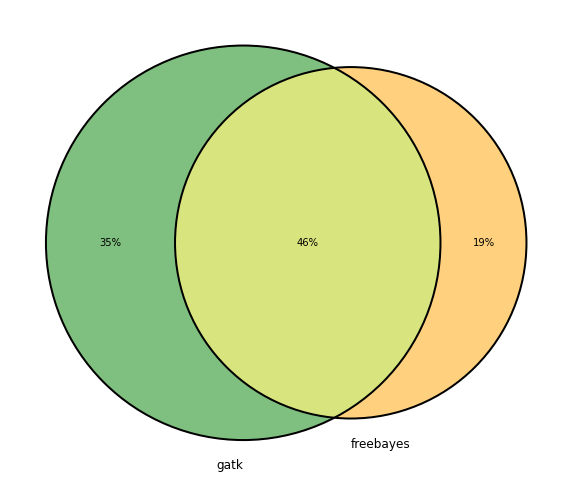

In [52]:
gatk_set = set(gatk_100genes_VT_filtered['CHROM_POS'].tolist())
free_set = set(free_100genes_VT_filtered['CHROM_POS'].tolist())
set_list = [gatk_set, free_set]
total = len(gatk_set.union(free_set))
plt.figure(figsize=(10,10))
venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
# venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5)
venn2_circles(subsets = set_list)
plt.show()

#### freebayes (1 gap) vs. freebayes (75 gap)

Comapre overlap in SNP set between `freebayes` run with `--max-complex-gap 1 and `freebayes` run with `--max-complex-gap 75`

In [26]:
dfs = []
with open('../resources/100genes_sorted_75gap.region', 'r') as f:
    
    lines = f.readlines()
    for l in lines:
        region = l.strip()
        CHROM = str(region.split(':')[0])
        START = int(region.split(':')[1].split('-')[0])
        END = int(region.split(':')[1].split('-')[1])
        
        df = free_100genes_VT_filtered[(free_100genes_VT_filtered['CHROM'] == CHROM) & 
                                      (free_100genes_VT_filtered['POS'] > START) &
                                      (free_100genes_VT_filtered['POS'] < END)]
        dfs.append(df)
free_1gap_VT_filtered_regions = pd.concat(dfs).reset_index()

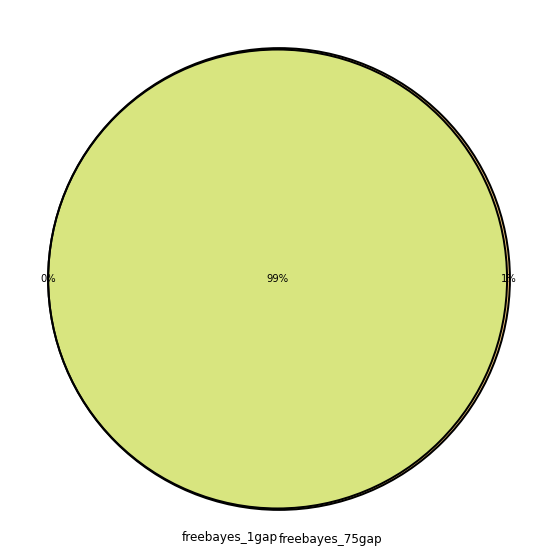

In [30]:
free1gap_set = set(free_1gap_VT_filtered_regions['CHROM_POS'])
free75gap_set = set(free_100genes_VT_filtered_75gap['CHROM_POS'])
set_list = [free1gap_set, free75gap_set]
total = len(free1gap_set.union(free75gap_set))
plt.figure(figsize=(10,10))
venn2(subsets = set_list, set_labels = ('freebayes_1gap', 'freebayes_75gap'), set_colors=('green', 'orange'), alpha = 0.5, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
# venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5)
venn2_circles(subsets = set_list)
plt.show()

### Unfiltered

In [53]:
gatk_100genes_vcf_unfiltered_path = '../analysis/vcf/100genes/gatk/100randomGenes_120samples_snps.vcf.gz'
gatk_100genes_VT_unfiltered = create_merged_variantTable(gatk_100genes_vcf_unfiltered_path, chromosomes)

In [54]:
%%capture
free_100genes_vcf_unfiltered_path = '../analysis/vcf/100genes/freebayes/100randomGenes_120samples_snps.vcf.gz'
free_100genes_VT_unfiltered = create_merged_variantTable(free_100genes_vcf_unfiltered_path, chromosomes)

In [29]:
gatk_set = set(gatk_100genes_VT_unfiltered['CHROM_POS'].tolist())
free_set = set(free_100genes_VT_unfiltered['CHROM_POS'].tolist())
set_list = [gatk_set, free_set]
total = len(gatk_set.union(free_set))
plt.figure(figsize=(10,10))
venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
# venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5)
venn2_circles(subsets = set_list)
plt.show()

NameError: name 'gatk_100genes_VT_unfiltered' is not defined

## Two genomes

In [61]:
gatk_100genes_twoGenomes_path = '../../../sequencingTwoGenomes_Cyan-Acyan/analysis/vcf/100genes/gatk/vcftools_filtered/gatk_100randomGenes_twoHighCoverageGenomes_snps_vcftools_filtered.recode.vcf.gz'
gatk_100genes_VT_twoGenomes = create_merged_variantTable(gatk_100genes_twoGenomes_path, chromosomes)

In [62]:
%%capture
free_100genes_twoGenomes_path = '../../../sequencingTwoGenomes_Cyan-Acyan/analysis/vcf/100genes/freebayes/vcftools_filtered/freebayes_100randomGenes_twoHighCoverageGenomes_snps_vcftools_filtered.recode.vcf.gz'
free_100genes_VT_twoGenomes = create_merged_variantTable(free_100genes_twoGenomes_path, chromosomes)

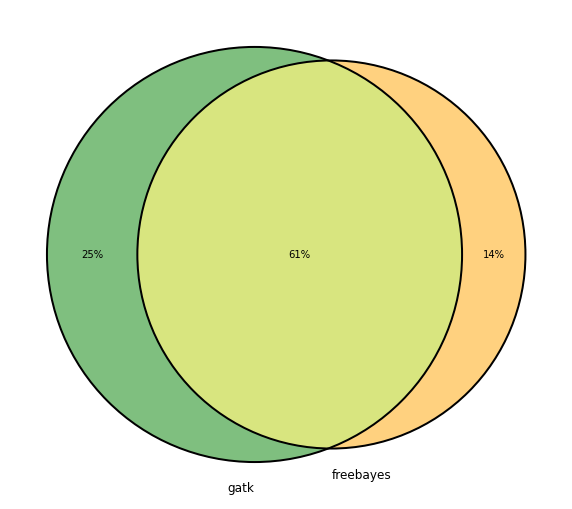

In [64]:
gatk_set = set(gatk_100genes_VT_twoGenomes['CHROM_POS'].tolist())
free_set = set(free_100genes_VT_twoGenomes['CHROM_POS'].tolist())
set_list = [gatk_set, free_set]
total = len(gatk_set.union(free_set))
plt.figure(figsize=(10,10))
venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5, subset_label_formatter=lambda x: f"{(x/total):1.0%}")
# venn2(subsets = set_list, set_labels = ('gatk', 'freebayes'), set_colors=('green', 'orange'), alpha = 0.5)
venn2_circles(subsets = set_list)
plt.show()

In [67]:
def percent_true(snp_list_1, snp_list_2):

    total_true = len(snp_list_1)

    overlap = list(set(snp_list_1).intersection(set(snp_list_2)))
    count_true = len(overlap)
    
    percent_true = round((count_true / total_true) * 100, 2)
    
    return percent_true

In [65]:
true_snps = list(set(gatk_100genes_VT_twoGenomes['CHROM_POS']).intersection(set(free_100genes_VT_twoGenomes['CHROM_POS'])))

### Filtered

In [68]:
freebayes_snps_filtered = list(free_100genes_VT_filtered['CHROM_POS'])
percent_true(true_snps, freebayes_snps_filtered)

52.26

In [69]:
gatk_snps_filtered = list(gatk_100genes_VT_filtered['CHROM_POS'])
percent_true(true_snps, gatk_snps_filtered)

53.59

### Unfiltered

In [70]:
freebayes_snps_unfiltered = list(free_100genes_VT_unfiltered['CHROM_POS'])
percent_true(true_snps, freebayes_snps_unfiltered)

67.82

In [71]:
gatk_snps_unfiltered = list(gatk_100genes_VT_unfiltered['CHROM_POS'])
percent_true(true_snps, gatk_snps_unfiltered)

92.33

## Plot SFS for `freebayes` and `GATK` SNPs

Plot SFS for SNPs for both programs to see if the different variant sets <br>
are likely to influence downstream inferences based on the SFS.

In [39]:
def get_folded_sfs(vcf):
    
    # Get SFS as numpy array
    GTarray = allel.GenotypeArray(vcf['calldata/GT'])
    alleleCounts = GTarray.count_alleles()
    sfs = allel.sfs_folded(alleleCounts)
    
    return sfs

### 100 random genes

In [40]:
gatk_100genes_filtered_folded_sfs = get_folded_sfs(gatk_100genes_vcf_filtered)
free_100genes_filtered_folded_sfs = get_folded_sfs(free_100genes_vcf_filtered)

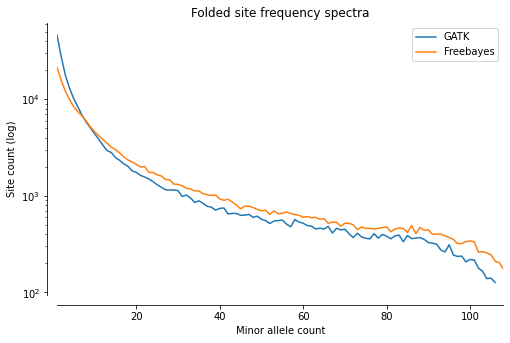

In [41]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
allel.plot_sfs_folded(gatk_100genes_filtered_folded_sfs, ax=ax, label='GATK', yscale='log')
allel.plot_sfs_folded(free_100genes_filtered_folded_sfs, ax=ax, label='Freebayes', yscale='log')
ax.legend()
ax.set_title('Folded site frequency spectra')
ax.set_ylabel('Site count (log)')
ax.set_xlabel('Minor allele count');

## Plot MAF for overlapping SNPs

Look at allele frequency estimates for SNPs called by both programs. <br>

### 100 random genes 

- Only includes SNPs called along chromosome 1, but still across 120 samples

#### GATK vs. freebayes (1 gap)

- MAF correlation for overlapping SNPs following filtering using `vcftools`

In [44]:
chromosomes = np.unique(gatk_100genes_vcf_filtered['variants/CHROM'])

In [45]:
gatk_100genes_vcf_filtered_path = '../analysis/vcf/100genes/gatk/vcftools_filtered/gatk_100randomGenes_120samples_snps_vcftools_filtered.recode.vcf.gz'
gatk_variantTables = []
for chrom in chromosomes:
    variantTable = import_variantTable(gatk_100genes_vcf_filtered_path, chrom=chrom, filter_biallelic=False)
    gatk_variantTables.append(variantTable)

In [46]:
%%capture
free_100genes_vcf_filtered_path = '../analysis/vcf/100genes/freebayes/vcftools_filtered/freebayes_100randomGenes_120samples_snps_vcftools_filtered.recode.vcf.gz'
free_variantTables = []
for chrom in chromosomes:
    variantTable = import_variantTable(free_100genes_vcf_filtered_path, chrom=chrom, filter_biallelic=False)
    free_variantTables.append(variantTable)

In [28]:
def get_intersection_snps(variantTable1, variantTable2):
    
    sortedIndex1 = allel.SortedIndex(variantTable1['POS'])
    sortedIndex2 = allel.SortedIndex(variantTable2['POS'])
    
    vt1_intersection, vt2_intersection = sortedIndex1.locate_intersection(sortedIndex2)
    
    vt1_intersection_snps = variantTable1[vt1_intersection]
    vt2_intersection_snps = variantTable2[vt2_intersection]
        
    return vt1_intersection_snps, vt2_intersection_snps

In [48]:
gatk_intersectionTables = []
free_intersectionTables = []
for i in range(len(chromosomes)):
    gatk_table =  gatk_variantTables[i]
    free_table =  free_variantTables[i]
    gatk_intersection_snps, free_intersection_snps = get_intersection_snps(gatk_table, free_table)
    gatk_intersectionTables.append(gatk_intersection_snps)
    free_intersectionTables.append(free_intersection_snps)

In [49]:
gatk_intersection_mergedDF = pd.concat(map(variant_table_to_dataframe, gatk_intersectionTables)).reset_index()
free_intersection_mergedDF = pd.concat(map(variant_table_to_dataframe, free_intersectionTables)).reset_index()

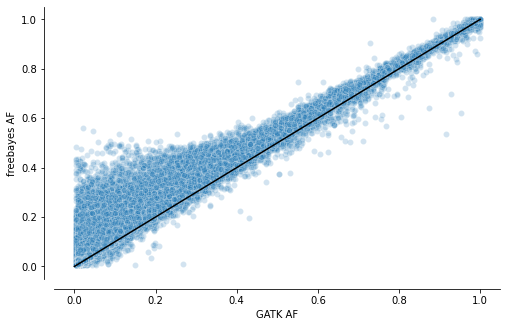

In [50]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sns.scatterplot(gatk_intersection_mergedDF['AF_1'], free_intersection_mergedDF['AF_1'], alpha = 0.2)
sns.lineplot(x=[0, 1], y=[0, 1], ax=ax, color='black')
ax.set_ylabel("freebayes AF")
ax.set_xlabel("GATK AF")
plt.show()

#### freebayes (1 gap) vs. freebayes (75 gap)

In [46]:
free_intersection = free1gap_set.intersection(free75gap_set)
free_1gap_VT_filtered_regions_intersection = free_1gap_VT_filtered_regions[free_1gap_VT_filtered_regions['CHROM_POS'].isin(free_intersection)].sort_values('CHROM_POS')
free_100genes_VT_filtered_75gap_intersection = free_100genes_VT_filtered_75gap[free_100genes_VT_filtered_75gap['CHROM_POS'].isin(free_intersection)].sort_values('CHROM_POS')

In [73]:
one = list(free_1gap_VT_filtered_regions_intersection['AF_1'])
two = list(free_100genes_VT_filtered_75gap_intersection['AF_1'])

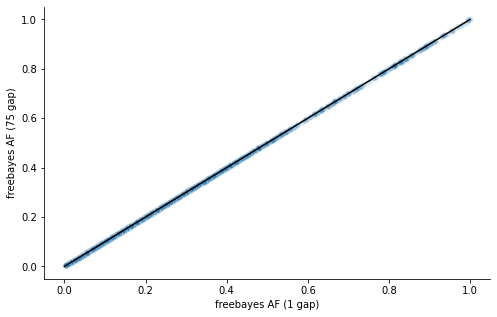

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax)
sns.scatterplot(one, two, alpha = 0.2)
sns.lineplot(x=[0, 1], y=[0, 1], ax=ax, color='black')
ax.set_ylabel("freebayes AF (75 gap)")
ax.set_xlabel("freebayes AF (1 gap)")
plt.show()

### Low frequecy bias

- Extract SNPs with `GATK` AF < 0.2 but `freebayes` AF > 0.4
- Create Pandas df out of positions with `GATK` and `freebayes` INFO for sites

In [18]:
manual_check_freeTooHigh = []
for index, row in gatk_intersection_mergedDF.iterrows():
    gatk_af = gatk_intersection_mergedDF.iloc[index]['AF_1']
    free_af = free_intersection_mergedDF.iloc[index]['AF_1']
    if gatk_af < 0.2 and free_af > 0.4:
        manual_check_freeTooHigh.append(index)
manual_check_freeTooHigh

[1907,
 1908,
 5163,
 8871,
 8872,
 13456,
 15200,
 15483,
 17055,
 17300,
 17449,
 23397,
 25854,
 28753,
 28754,
 28756,
 34911,
 34912,
 35531,
 36213,
 36722,
 43908,
 46058,
 52468,
 52623,
 52661,
 52683,
 53166,
 56374,
 57920,
 63831,
 64006,
 64234,
 67452,
 67597,
 67625,
 67706,
 67729,
 67763,
 67764,
 67766,
 70767,
 71619,
 72934,
 73478,
 78061,
 78476,
 78477,
 78478,
 78480,
 78863,
 80158,
 80584,
 83052,
 84072,
 84103,
 84155,
 87310,
 87311,
 87359,
 88876,
 88940,
 88941,
 89183,
 90542,
 95911,
 98546,
 99622,
 100391,
 102671,
 103278,
 105019,
 105190,
 105877,
 107380,
 107476,
 107836,
 108111,
 109696,
 109969,
 109971,
 110649,
 110650,
 111520,
 112521,
 115233,
 115234,
 115235,
 117905]

In [19]:
gatk_toCheck_lowFreqBias = gatk_intersection_mergedDF.iloc[manual_check_freeTooHigh]
gatk_toCheck_lowFreqBias.columns = [str(col) + '_gatk' for col in gatk_toCheck_lowFreqBias.columns]

In [20]:
free_toCheck_lowFreqBias = free_intersection_mergedDF.iloc[manual_check_freeTooHigh]
free_toCheck_lowFreqBias.columns = [str(col) + '_free' for col in free_toCheck_lowFreqBias.columns]

In [21]:
toCheck_lowFreqBias = pd.merge(gatk_toCheck_lowFreqBias, free_toCheck_lowFreqBias, left_index=True, right_index=True)
toCheck_lowFreqBias = toCheck_lowFreqBias.sort_index(axis=1).drop(columns=['index_free', 'index_gatk', 'POS_free', 'CHROM_free']).rename(columns={"CHROM_gatk": "CHROM", "POS_gatk": "POS"})

In [22]:
cols = toCheck_lowFreqBias.columns.tolist()
cols.insert(0, cols.pop(cols.index('CHROM')))
cols.insert(1, cols.pop(cols.index('POS')))
toCheck_lowFreqBias = toCheck_lowFreqBias[cols]
toCheck_lowFreqBias['Class'] = 'lowFreqBias'

### `GATK` singletons compared to `freebayes`

- Extract positions where `GATK` called site a singleton but `freebayes` called otherwise

In [23]:
# def get_singletons(vcf):
    
#     GTarray = allel.GenotypeArray(vcf['calldata/GT'])
#     alleleCounts = GTarray.count_alleles()
#     singletons = alleleCounts.is_singleton(allele=1)
    
#     return singletons

In [24]:
gatk_variantTables_mergedDF = pd.concat(map(variant_table_to_dataframe, gatk_variantTables)).reset_index()
gatk_variantTables_mergedDF['CHROMPOS'] = gatk_variantTables_mergedDF['CHROM'].astype(str) + gatk_variantTables_mergedDF['POS'].astype(str)
free_variantTables_mergedDF = pd.concat(map(variant_table_to_dataframe, free_variantTables)).reset_index()
free_variantTables_mergedDF['CHROMPOS'] = free_variantTables_mergedDF['CHROM'].astype(str) + free_variantTables_mergedDF['POS'].astype(str)

In [25]:
gatk_singletons_df = gatk_variantTables_mergedDF[gatk_variantTables_mergedDF['AC_1'] == 1]
free_singletons_df = free_variantTables_mergedDF[free_variantTables_mergedDF['AC_1'] == 1]

In [26]:
common = gatk_singletons_df.merge(free_variantTables_mergedDF, on=['CHROMPOS'], indicator=True)
gatk_uniqueSingletons = gatk_singletons_df[(~gatk_singletons_df['CHROMPOS'].isin(common['CHROMPOS']))].drop(columns=['CHROMPOS'])
gatk_uniqueSingletons.columns = [str(col) + '_gatk' for col in gatk_uniqueSingletons.columns]
gatk_uniqueSingletons = gatk_uniqueSingletons.sort_index(axis=1).drop(columns=['index_gatk']).rename(columns={"CHROM_gatk": "CHROM", "POS_gatk": "POS"})

In [27]:
cols = gatk_uniqueSingletons.columns.tolist()
cols.insert(0, cols.pop(cols.index('CHROM')))
cols.insert(1, cols.pop(cols.index('POS')))
gatk_uniqueSingletons = gatk_uniqueSingletons[cols]
gatk_uniqueSingletons['Class'] = 'gatkSingletons_notInFreebayes'

In [28]:
gatk_commonSingletons = gatk_singletons_df[(gatk_singletons_df['CHROMPOS'].isin(common['CHROMPOS']))].drop(columns=['CHROMPOS']).reset_index()
gatk_commonSingletons.columns = [str(col) + '_gatk' for col in gatk_commonSingletons.columns]

In [29]:
free_commonSingletons = free_variantTables_mergedDF[(free_variantTables_mergedDF['CHROMPOS'].isin(common['CHROMPOS']))].drop(columns=['CHROMPOS']).reset_index()
free_commonSingletons.columns = [str(col) + '_free' for col in free_commonSingletons.columns]

In [30]:
toCheck_commonSingletons = pd.merge(gatk_commonSingletons, free_commonSingletons, left_index=True, right_index=True)
toCheck_commonSingletons = toCheck_commonSingletons.sort_index(axis=1).drop(columns=['level_0_gatk', 'level_0_free', 'index_free', 'index_gatk', 'POS_free', 'CHROM_free']).rename(columns={"CHROM_gatk": "CHROM", "POS_gatk": "POS"})

In [31]:
cols = toCheck_commonSingletons.columns.tolist()
cols.insert(0, cols.pop(cols.index('CHROM')))
cols.insert(1, cols.pop(cols.index('POS')))
toCheck_commonSingletons = toCheck_commonSingletons[cols]
toCheck_commonSingletons['Class'] = 'gatkSingletons_inFreebayes'

In [32]:
np.random.seed(42)
toCheck_commonSingletons_sample = toCheck_commonSingletons.sample(n = 50)
toCheck_gatk_uniqueSingletons_sample = gatk_uniqueSingletons.sample(n = 50)

In [33]:
toCheck_allSites = pd.concat([toCheck_lowFreqBias, toCheck_commonSingletons_sample, toCheck_gatk_uniqueSingletons_sample]).sort_values(by=['CHROM', 'POS'])

In [34]:
toCheck_allSites.to_csv('../data/manual_snp_inspection/toCheck_MAFcorr.csv', )

,CHROM,POS,AC_1_free,AC_1_gatk,AF_1_free,AF_1_gatk,ALT_1_free,ALT_1_gatk,AN_free,AN_gatk,DP_free,DP_gatk,QUAL_free,QUAL_gatk,REF_free,REF_gatk,Class
149,CM019101.1,8899537,4.0,1,0.017544,0.004425,T,T,228.0,226,793.0,670,89.800003,52.650002,A,A,gatkSingletons_inFreebayes
2740,CM019101.1,8905403,NaN,1,NaN,0.004386,NaN,T,NaN,228,NaN,1033,NaN,124.820000,NaN,A,gatkSingletons_notInFreebayes
1907,CM019101.1,11353694,99.0,3,0.426724,0.015000,G,G,232.0,198,1108.0,1081,5422.379883,279.299988,A,A,lowFreqBias
1908,CM019101.1,11353702,97.0,2,0.418103,0.010000,T,T,232.0,196,1058.0,1046,4162.029785,222.110001,C,C,lowFreqBias
357,CM019101.1,11415365,1.0,1,0.004167,0.004167,T,T,240.0,240,2613.0,2485,216.539993,280.220001,C,C,gatkSingletons_inFreebayes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14515,CM019116.1,35010899,7.0,1,0.029167,0.004274,A,A,240.0,234,5697.0,4567,900.820007,304.570007,C,C,gatkSingletons_inFreebayes
14557,CM019116.1,35014904,1.0,1,0.004464,0.004464,C,C,224.0,224,760.0,746,48.480000,61.599998,A,A,gatkSingletons_inFreebayes
261515,CM019116.1,39421760,NaN,1,NaN,0.004348,NaN,T,NaN,230,NaN,706,NaN,145.330002,NaN,C,gatkSingletons_notInFreebayes
14662,CM019116.1,39424510,1.0,1,0.004310,0.004310,A,A,232.0,232,1462.0,1193,86.849998,156.720001,C,C,gatkSingletons_inFreebayes


In [86]:
bed_out = '../resources/100genes_MAFcorr_toCheck.bed'
with open(bed_out, 'w') as f:
    for index, row in toCheck_allSites.iterrows():
        chrom = row['CHROM']
        start = row['POS'] - 150
        end = row['POS'] + 150
        
        f.write('{0}\t{1}\t{2}\n'.format(chrom, start, end))

#### Raw

- MAF correlation among overlapping SNPs in raw dataset

In [30]:
gatk_100genes_vcf_raw_path = '../analysis/vcf/100genes/gatk/100randomGenes_120samples_snps.vcf.gz'
gatk_100genes_raw_variantTable = import_variantTable(gatk_100genes_vcf_filtered_path, chrom='CM019101.1', filter_biallelic=True)

In [31]:
free_100genes_vcf_raw_path = '../analysis/vcf/100genes/freebayes/100randomGenes_120samples_snps.vcf.gz'
free_100genes_raw_variantTable = import_variantTable(free_100genes_vcf_raw_path, chrom='CM019101.1', filter_biallelic=True)

/home/santang3/.local/share/virtualenvs/gwsd-1Dt4D4sP/lib/python3.7/site-packages/allel/io/vcf_read.py:1736: UserWarning: multiple INFO headers for 'AC'
  warnings.warn('multiple INFO headers for %r' % k)
/home/santang3/.local/share/virtualenvs/gwsd-1Dt4D4sP/lib/python3.7/site-packages/allel/io/vcf_read.py:1736: UserWarning: multiple INFO headers for 'AF'
  warnings.warn('multiple INFO headers for %r' % k)
/home/santang3/.local/share/virtualenvs/gwsd-1Dt4D4sP/lib/python3.7/site-packages/allel/io/vcf_read.py:1736: UserWarning: multiple INFO headers for 'DP'
  warnings.warn('multiple INFO headers for %r' % k)


In [32]:
gatk_100genes_raw_intersection, free_100genes_raw_intersection = get_intersection_indices(gatk_100genes_raw_variantTable, free_100genes_raw_variantTable)

In [33]:
gatk_100genes_chr1_only_raw_intersection_snps = gatk_100genes_raw_variantTable[gatk_100genes_raw_intersection]
free_100genes_chr1_only_raw_intersection_snps = free_100genes_raw_variantTable[free_100genes_raw_intersection]

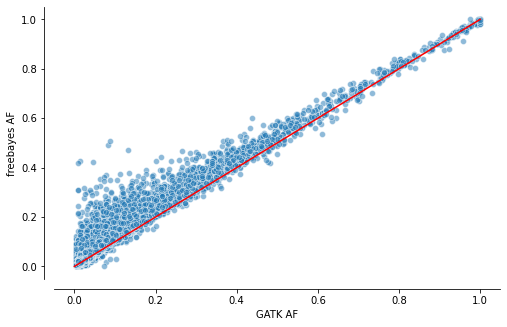

In [36]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.despine(ax=ax, offset=10)
sns.scatterplot(gatk_100genes_chr1_only_raw_intersection_snps['AF_1'], free_100genes_chr1_only_raw_intersection_snps['AF_1'], alpha = 0.5)
sns.lineplot(x=[0, 1], y=[0, 1], ax=ax, color='red')
ax.set_ylabel("freebayes AF")
ax.set_xlabel("GATK AF")
plt.show()

In [290]:
gatk_1_index[gatk_intersection][1907]

11353694

In [291]:
free_1_index[free_intersection][1907]

11353694

In [301]:
gatk_1_GTarray[1907]

0,1,2,3,4,...,102,103,104,105,106
0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


In [302]:
free_1_GTarray[1907]

0,1,2,3,4,...,104,105,106,107,108
0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,./.,0/0
